In [71]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns 

In [40]:
data=pd.read_csv("X_train.csv")
df=data.copy()

In [65]:
# Différences inter-nationales
df["TEMP_DIFF"]=df["DE_TEMP"]-df["FR_TEMP"]
df["CONSUMPTION_DIFF"]=df["DE_CONSUMPTION"]-df["FR_CONSUMPTION"]
df["PRODUCTION_DIFF"]=(df["DE_GAS"]+df["DE_COAL"]+df["DE_HYDRO"]+df["DE_NUCLEAR"]+df["DE_SOLAR"]+df["DE_WINDPOW"]+df["DE_LIGNITE"])-(df["FR_GAS"]+df["FR_COAL"]+df["FR_HYDRO"]+df["FR_NUCLEAR"]+df["FR_SOLAR"]+df["FR_WINDPOW"])
df["PRODUCTION_RENEWABLE_DIFF"] = (df["DE_HYDRO"]+df["DE_SOLAR"]+df["DE_WINDPOW"])-(df["FR_HYDRO"]+df["FR_SOLAR"]+df["FR_WINDPOW"])
df["PRODUCTION_FOSSIL_DIFF"] = (df["DE_GAS"]+df["DE_COAL"]+df["DE_NUCLEAR"]+df["DE_LIGNITE"])-(df["FR_GAS"]+df["FR_COAL"]+df["FR_NUCLEAR"])

# Charge du réseau 
df["FR_NET_BALANCE"] = df["FR_NET_IMPORT"] - df["FR_NET_EXPORT"]
df["DE_NET_BALANCE"] = df["DE_NET_IMPORT"] - df["DE_NET_EXPORT"]
df["FR_RESIDUAL_RATIO"] = df["FR_RESIDUAL_LOAD"] / (df["FR_CONSUMPTION"] + 1e-3)
df["DE_RESIDUAL_RATIO"] = df["DE_RESIDUAL_LOAD"] / (df["DE_CONSUMPTION"] + 1e-3)

# Efficacité énergétique des EnR 
df["FR_WIND_EFFECTIVE"] = df["FR_WIND"] * df["FR_WINDPOW"]
df["DE_WIND_EFFECTIVE"] = df["DE_WIND"] * df["DE_WINDPOW"]
df["FR_HYDRO_EFFECTIVE"] = df["FR_RAIN"] * df["FR_HYDRO"]
df["DE_HYDRO_EFFECTIVE"] = df["DE_RAIN"] * df["DE_HYDRO"]

# Détermination de la saison avec la méthode des quantiles
q25 = df["FR_TEMP"].quantile(0.25)
q75 = df["FR_TEMP"].quantile(0.75)

def approx_saison(temp):
    if temp <= q25:
        return "hiver"
    elif temp >= q75:
        return "été"
    else:
        return "mi-saison"

df["SAISON_ESTIMEE"] = df["FR_TEMP"].apply(approx_saison)
df.describe()

# Détermination de la saion en fitant une loi log-normale
shape, loc, scale = stats.lognorm.fit(df["FR_TEMP"].dropna())



# Seuil pour les 25% les plus froids
seuil_hiver = lognorm.ppf(0.25, shape, loc=loc, scale=scale)

# Seuil pour les 25% les plus chauds
seuil_ete = lognorm.ppf(0.75, shape, loc=loc, scale=scale)

def saison_par_loi(temp):
    if temp <= seuil_hiver:
        return "hiver"
    elif temp >= seuil_ete:
        return "été"
    else:
        return "mi-saison"

df["SAISON_PAR_LOI"] = df["FR_TEMP"].apply(saison_par_loi)



C:\Users\qevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_continuous_distns.py:6902: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


In [52]:
from scipy.stats import shapiro

stat, p_value = shapiro(df["DE_TEMP"].dropna())
print(f"Statistique : {stat:.4f}, p-value : {p_value:.4f}")

if p_value > 0.05:
    print("✅ La distribution semble normale (on ne rejette pas H0).")
else:
    print("❌ La distribution ne suit pas une loi normale (H0 rejetée).")

Statistique : 0.9908, p-value : 0.0000
❌ La distribution ne suit pas une loi normale (H0 rejetée).


In [53]:
from scipy.stats import kstest, expon, norm, lognorm, gamma, beta

data = df["FR_TEMP"].dropna()

# Liste de lois candidates
lois = {
    "normale": norm,
    "log-normale": lognorm,
    "exponentielle": expon,
    "gamma": gamma,
    "bêta": beta
}

for nom, loi in lois.items():
    try:
        params = loi.fit(data)
        stat, p = kstest(data, loi.name, args=params)
        print(f"{nom:15s} | KS stat: {stat:.4f} | p-value: {p:.4f}")
    except Exception as e:
        print(f"{nom:15s} | erreur : {e}")


normale         | KS stat: 0.0189 | p-value: 0.6909
log-normale     | KS stat: 0.0181 | p-value: 0.7433
exponentielle   | KS stat: 0.4751 | p-value: 0.0000
gamma           | KS stat: 0.0214 | p-value: 0.5356
bêta            | KS stat: 0.0249 | p-value: 0.3464


C:\Users\qevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_continuous_distns.py:6902: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
C:\Users\qevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\qevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [54]:
from scipy.stats import lognorm
import numpy as np

data = df["FR_TEMP"].dropna()

# Ajustement
shape, loc, scale = lognorm.fit(data)

print(f"shape: {shape:.4f}, loc: {loc:.4f}, scale: {scale:.4f}")


shape: 0.0043, loc: -230.0958, scale: 230.1012


C:\Users\qevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_continuous_distns.py:6902: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


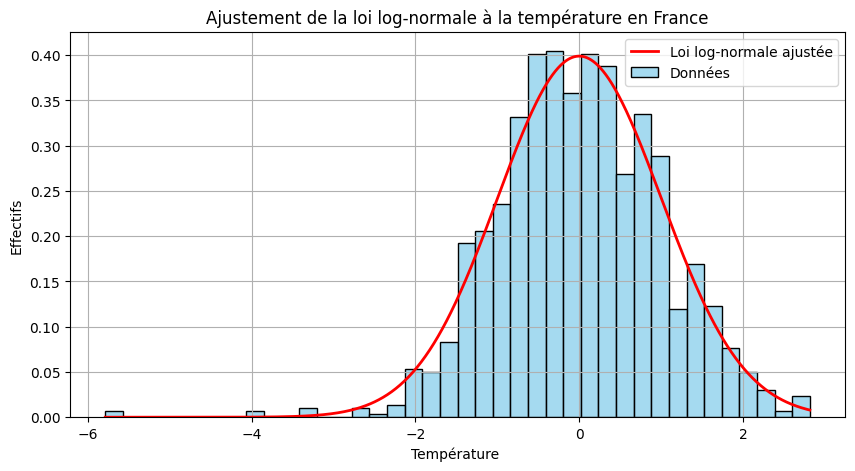

In [78]:
x = np.linspace(data.min(), data.max(), 1000)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

plt.figure(figsize=(10,5))
sns.histplot(data, bins=40, stat="density", color="skyblue", label="Données")
plt.plot(x, pdf, 'r-', label="Loi log-normale ajustée", linewidth=2)
plt.legend()
plt.title("Ajustement de la loi log-normale à la température en France")
plt.xlabel("Température ")
plt.ylabel("Effectifs")
plt.grid(True)
plt.show()

In [68]:
print(df["SAISON_ESTIMEE"].value_counts(normalize=True))
print(df["SAISON_PAR_LOI"].value_counts(normalize=True))


SAISON_ESTIMEE
mi-saison    0.53012
été          0.23494
hiver        0.23494
Name: proportion, dtype: float64
SAISON_PAR_LOI
mi-saison    0.528112
été          0.242303
hiver        0.229585
Name: proportion, dtype: float64


C:\Users\qevan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_continuous_distns.py:6902: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


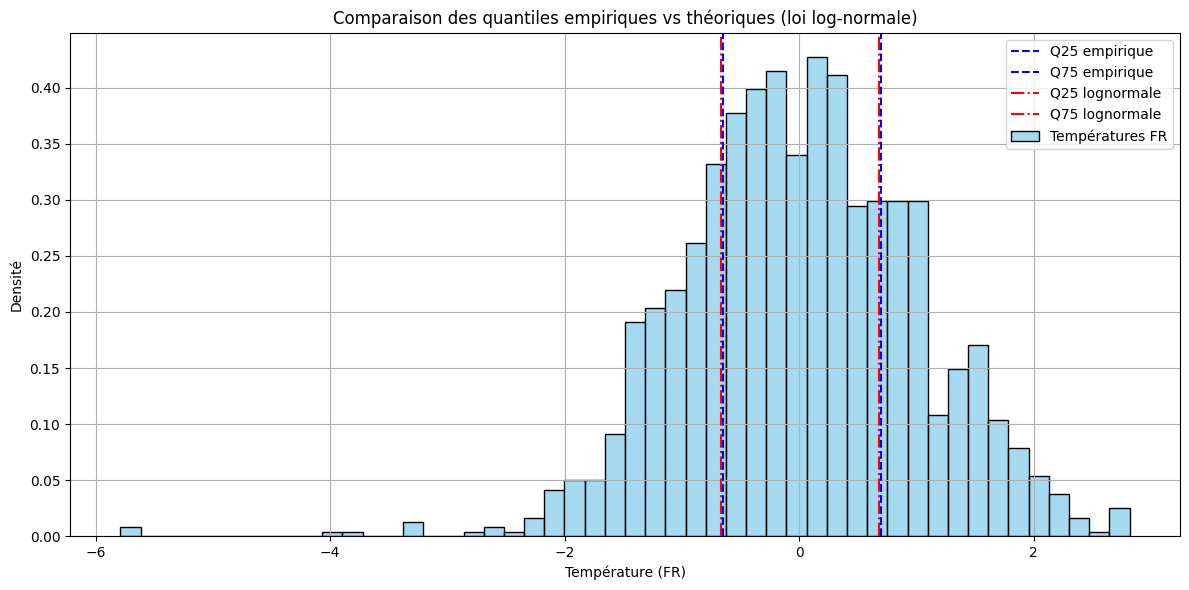

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm

# 1. Données
data = df["FR_TEMP"].dropna()

# 2. Seuils empiriques
q25_emp = data.quantile(0.25)
q75_emp = data.quantile(0.75)

# 3. Fit de la loi lognormale
shape, loc, scale = lognorm.fit(data)
q25_theo = lognorm.ppf(0.25, shape, loc=loc, scale=scale)
q75_theo = lognorm.ppf(0.75, shape, loc=loc, scale=scale)

# 4. Histogramme avec les deux paires de seuils
plt.figure(figsize=(12,6))
sns.histplot(data, bins=50, stat="density", color="skyblue", label="Températures FR")

# Seuils empiriques
plt.axvline(q25_emp, color="blue", linestyle="--", label="Q25 empirique")
plt.axvline(q75_emp, color="blue", linestyle="--", label="Q75 empirique")

# Seuils théoriques
plt.axvline(q25_theo, color="red", linestyle="-.", label="Q25 lognormale")
plt.axvline(q75_theo, color="red", linestyle="-.", label="Q75 lognormale")

# Légende et affichage
plt.title("Comparaison des quantiles empiriques vs théoriques (loi log-normale)")
plt.xlabel("Température (FR)")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
